# Loss Landscapes for CNNs
In this notebook, we show how Landscaper can be used to analyze a CNN trained on the CIFAR-10 dataset. 
(From https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
# might have issues with too many files being opened at once, this will prevent that
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

In [3]:
# Check if CUDA is available
device = "cpu"

In [4]:
# load in the data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
# setup the model
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.188
[1,  4000] loss: 1.905
[1,  6000] loss: 1.709
[1,  8000] loss: 1.598
[1, 10000] loss: 1.535
[1, 12000] loss: 1.493
[2,  2000] loss: 1.405
[2,  4000] loss: 1.395
[2,  6000] loss: 1.374
[2,  8000] loss: 1.346
[2, 10000] loss: 1.319
[2, 12000] loss: 1.308
Finished Training


In [8]:
PATH = './cifar_net.pth'

In [9]:
torch.save(net.state_dict(), PATH)

In [10]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [11]:
trunc_data = []
for idx, d in enumerate(trainloader):
    trunc_data.append(d)    
    if idx > 20:
        break

# Analyzing the loss landscape

In [12]:
from landscaper import LossLandscape, PyHessian

In [13]:
hessian_comp = PyHessian(net, criterion, trunc_data, device, try_cache=True)

Setting model to eval mode. PyHessian will not work with models in training mode!


In [14]:
def loss_function(model, data):
    batch_loss = 0
    for d in data: 
        tt, lbl_t = d
        output = model.forward(tt)
        loss = criterion(output, lbl_t)
        batch_loss += loss
    return batch_loss

In [15]:
with torch.backends.cudnn.flags(enabled=False):
    evals, evecs = hessian_comp.eigenvalues(top_n=3)

Err: 0.3720305878901198:   0%| | 0/100 [00:00<?, ?it/s]
Err: 0.3720305878901198:   3%| | 3/100 [00:00<00:03, 24
Err: 0.08530534616737256:   3%| | 3/100 [00:00<00:03, 2
Err: 0.13727918560462643:   3%| | 3/100 [00:00<00:03, 2
Err: 0.17578758733191802:   3%| | 3/100 [00:00<00:03, 2
Err: 0.17578758733191802:   6%| | 6/100 [00:00<00:03, 2
Err: 0.12598039167350136:   6%| | 6/100 [00:00<00:03, 2
Err: 0.05714390763312505:   6%| | 6/100 [00:00<00:03, 2
Err: 0.020702783494086743:   6%| | 6/100 [00:00<00:03, 
Err: 0.020702783494086743:   9%| | 9/100 [00:00<00:03, 
Err: 0.006893269449366529:   9%| | 9/100 [00:00<00:03, 
Err: 0.0022314653772727137:   9%| | 9/100 [00:00<00:03,
Err: 0.000716336967754484:  11%| | 11/100 [00:00<00:04,
Eigenvectors computed:  33%|▎| 1/3 [00:00<00:01,  1.95i
Err: 1.0339873135144184:   0%| | 0/100 [00:00<?, ?it/s]
Err: 1.0339873135144184:   3%| | 3/100 [00:00<00:03, 27
Err: 0.23236597280957885:   3%| | 3/100 [00:00<00:03, 2
Err: 0.07884925645226483:   3%| | 3/100 [00:00<0

In [16]:
with torch.backends.cudnn.flags(enabled=False):
    landscape = LossLandscape.compute(
    net,
    trunc_data,
    evecs,
    loss_function, # loss function
    dim=2,
    distance = 0.01,
    device=device,
)

Computing 1681 points in 2D space...


Computing 2D landscape: 100%|█| 1681/1681 [00:11<00:00,

Loss hypercube stats - min: 26.181983947753906, max: 29.56452751159668, mean: 26.91413620240202


In [17]:
landscape.save("cnn.npz")

In [18]:
landscape  = LossLandscape.load_from_npz("cnn.npz")

Attempting log-scale surface plot...


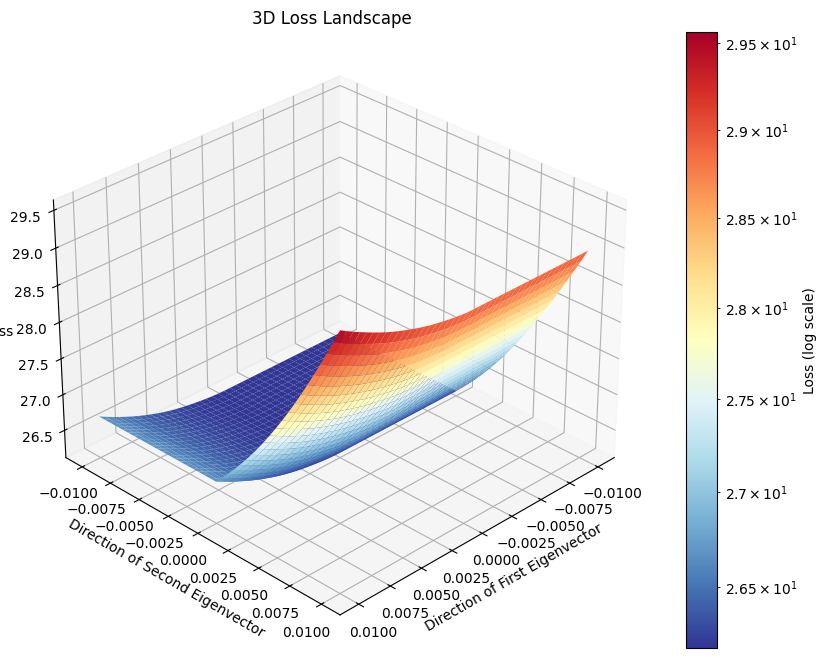

In [19]:
landscape.show()

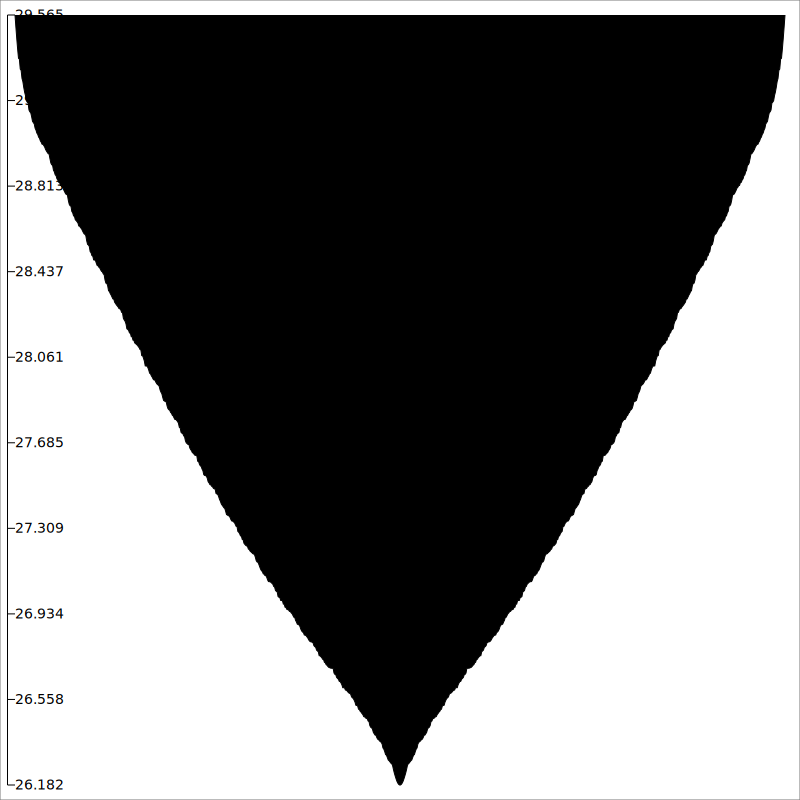

In [20]:
landscape.show_profile()

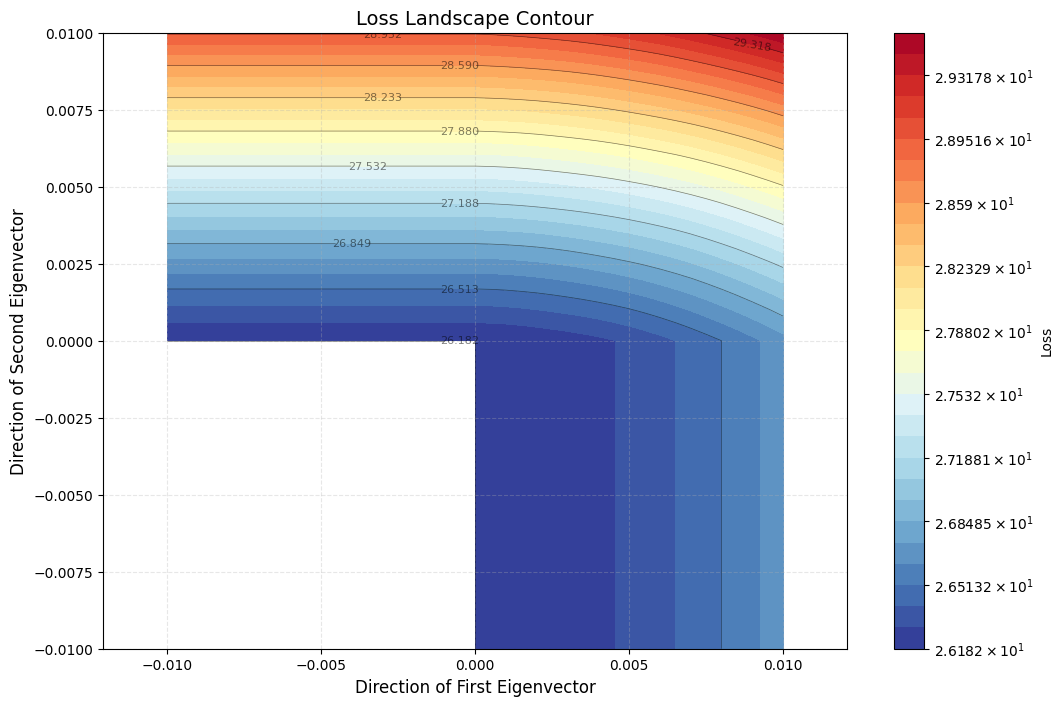

In [21]:
landscape.show_contour()

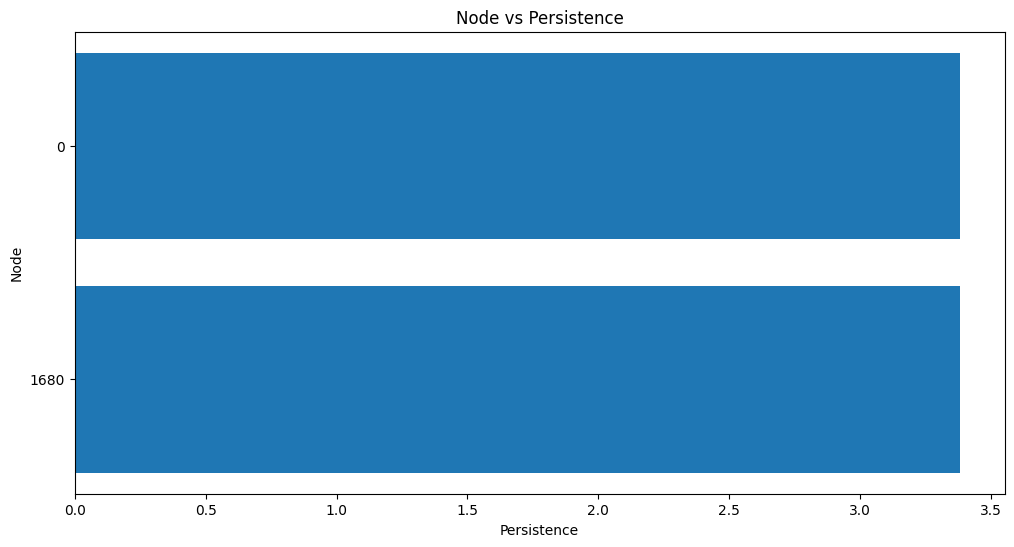

In [22]:
landscape.show_persistence_barcode()

In [23]:
# we can use this function to convert the merge tree 
# into a networkx graph and visualize it!
from landscaper.tda import digraph_mt
g = digraph_mt(landscape.get_sublevel_tree())

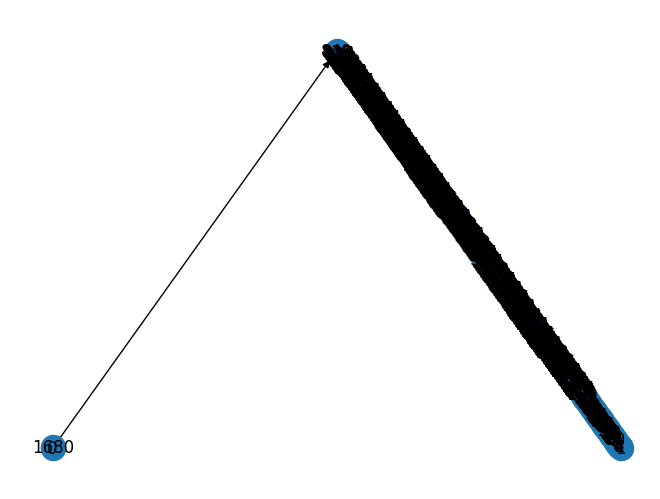

In [24]:
import networkx as nx
nx.draw_planar(g, with_labels=True)

In [29]:
len(g.nodes())

442

In [25]:
landscape.smad()

0.0